In [1]:
import os
import json
import numpy as np
import torch
import result
import pandas as pd
from rnn_model import LSTMNet, GRUNet
from utils import DotDict, Logger, rmse, rmse_tensor, boolean_string, get_dir, get_time, next_dir, model_dir, get_model
from get_dataset import get_time_data, get_stnn_data
from stnn import SaptioTemporalNN
import matplotlib.pyplot as plt
from matplotlib import axis
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
%matplotlib inline


In [2]:
%load_ext autoreload
%autoreload 1
%aimport result

## Data

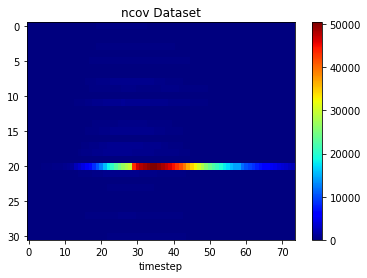

In [3]:
datadir = 'data'
dataset = 'ncov_confirmed'
data = get_time_data(datadir, dataset)

plt.figure('ncov Dataset')
plt.imshow(data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.title('ncov Dataset')
plt.xlabel('timestep')
plt.colorbar()

## Mode List

In [85]:
jar_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'output', 'jar'))
jar_result = result.Printer(jar_folder)
pd.options.display.max_rows = None
# a = jar_result.get_df(col=['train_loss', 'test_loss', 'mode']).sort_values('test_loss', ascending=True)
jar_df = jar_result.get_df(col=['train_loss', 'test_loss', 'true_loss', 'mode', 'nhid', 'nlayers', 'nz', 'dropout_d', 'simple_dec', 'seq_length', 'rnn_model']).sort_values('test_loss', ascending=True)
jar_df

,train_loss,test_loss,true_loss,mode,nhid,nlayers,nz,dropout_d,simple_dec,seq_length,rnn_model
concat-stnn_23-53-04-04-30,0.0572914,0.943266,346.882,refine,200,2,10,0.5,False,NaN,NaN
input-stnn_23-51-04-04-01,0.027215,1.06655,392.22,None,200,2,10,0.5,False,NaN,NaN
concat-stnn_10-40-05-04-57,0.0311778,1.09477,402.597,refine,20,4,2,0.5,False,NaN,NaN
input-stnn_23-53-04-04-56,0.021022,1.11136,408.697,refine,200,2,10,0.5,False,NaN,NaN
concat-stnn_10-40-05-04-11,0.132531,1.12701,414.453,None,20,4,2,0.5,False,NaN,NaN
input-stnn_10-39-05-04-04,0.0427263,1.14693,421.778,refine,20,4,1,0.5,False,NaN,NaN
concat-stnn_10-35-05-04-21,0.0396712,1.18518,435.843,discover,20,2,2,0.5,False,NaN,NaN
input-stnn_10-36-05-04-05,0.0172871,1.19795,440.543,None,20,2,5,0.5,False,NaN,NaN
input-stnn_10-35-05-04-28,0.0876548,1.2105,445.158,discover,20,2,2,0.5,False,NaN,NaN
input-stnn_10-36-05-04-46,0.100565,1.21936,448.415,refine,20,2,5,0.5,False,NaN,NaN


## Jar Exp 

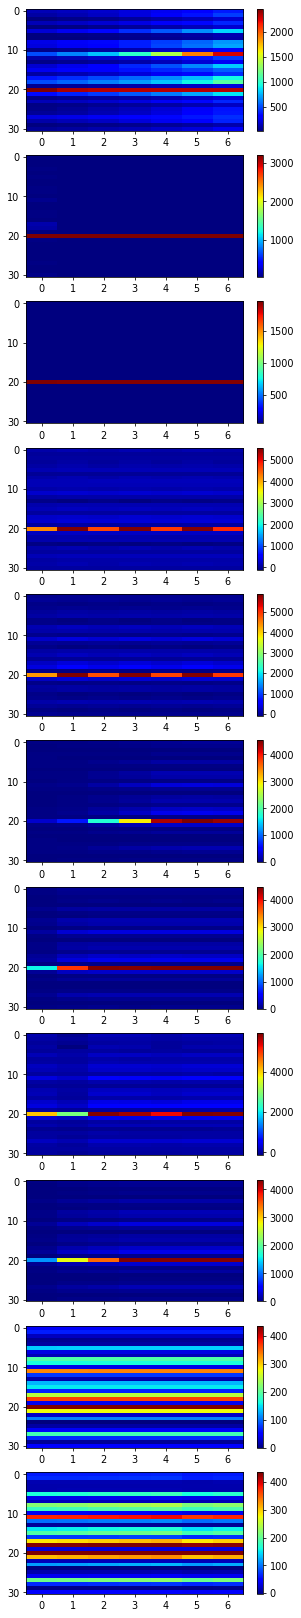

In [100]:
jar_exp = {}
jar_exp['STNN'] = 'ori-stnn_23-51-04-04-01'
jar_exp['STNN-R'] = 'ori-stnn_00-54-05-04-34'
jar_exp['STNN-D'] = 'ori-stnn_10-40-05-04-54'
jar_exp['STNN-v2'] = 'input-stnn_23-51-04-04-01'
jar_exp['STNN-v2-R'] = 'input-stnn_23-53-04-04-56'
jar_exp['STNN-v2-D'] = 'input-stnn_10-40-05-04-03'
jar_exp['STNN-v1'] = 'concat-stnn_10-40-05-04-11'
jar_exp['STNN-v1-R'] = 'concat-stnn_23-53-04-04-30'
jar_exp['STNN-v1-D'] = 'concat-stnn_10-35-05-04-21'
jar_exp['LSTM'] = 'keras-rnn_10-39-05-04-16'
jar_exp['GRU'] = 'keras-rnn_00-45-05-04-30'
jar = {}
jar_pred = {}
for k, v in jar_exp.items():
    jar[k] = result.Exp(v, folder)
    jar_pred[k] = jar[k].pred().numpy().T
plt.figure('Results', figsize=(5, 30), dpi=70)

# plt.subplot(11, 3, 1)
# plt.imshow(test_data, aspect='auto', cmap='jet')
# plt.colorbar()
# plt.title('ground truth')

for i, exp in enumerate(jar_pred):
    plt.subplot(11, 1, i + 1)
    plt.imshow(jar_pred[exp], aspect='auto', cmap='jet')
    plt.colorbar()

    # plt.subplot(11, 3, i * 3 + 3)
    # plt.imshow(np.abs(test_data - pred[exp]), aspect='auto')
    # plt.colorbar()
    # plt.title('{} absolute error'.format(exp))

In [105]:
jar_lis = []
for k, v in jar_exp.items():
    jar_lis.append(v)
jar_df.loc[jar_lis].to_excel('jan.xls')

## Feb Exp

In [88]:
feb_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'output', 'feb'))
feb_result = result.Printer(feb_folder)
pd.options.display.max_rows = None
# a = feb_result.get_df(col=['train_loss', 'test_loss', 'mode']).sort_values('test_loss', ascending=True)
feb_df = feb_result.get_df(col=['train_loss', 'test_loss', 'true_loss', 'mode', 'nhid', 'nlayers', 'nz', 'dropout_d', 'simple_dec', 'seq_length', 'rnn_model']).sort_values('test_loss', ascending=True)
feb_df

,train_loss,test_loss,true_loss,mode,nhid,nlayers,nz,dropout_d,simple_dec,seq_length,rnn_model
input-stnn_10-46-05-04-09,0.0298557,0.0391682,257.44,refine,20,4,2,0.9,True,NaN,NaN
input-stnn_10-47-05-04-02,0.0356295,0.0407576,267.886,discover,20,4,2,0.9,True,NaN,NaN
input-stnn_10-45-05-04-27,0.0165179,0.0422783,277.881,None,20,4,2,0.9,True,NaN,NaN
ori-stnn_00-09-05-04-39,0,0.0624913,410.735,refine,20,2,10,0.5,NaN,NaN,NaN
input-stnn_23-54-04-04-49,0.00515367,0.0700511,460.423,refine,200,2,10,0.5,False,NaN,NaN
ori-stnn_00-07-05-04-46,0,0.072216,474.651,None,20,2,10,0.5,NaN,NaN,NaN
concat-stnn_10-38-05-04-09,0.00683285,0.0741008,487.039,None,20,2,5,0.5,False,NaN,NaN
concat-stnn_23-51-04-04-35,0.00478158,0.0758851,498.768,None,200,2,10,0.5,False,NaN,NaN
ori-stnn_00-14-05-04-04,0,0.0774828,509.269,None,200,4,10,0.5,NaN,NaN,NaN
ori-stnn_00-35-05-04-01,0,0.0777196,510.824,discover,200,4,10,0.5,NaN,NaN,NaN


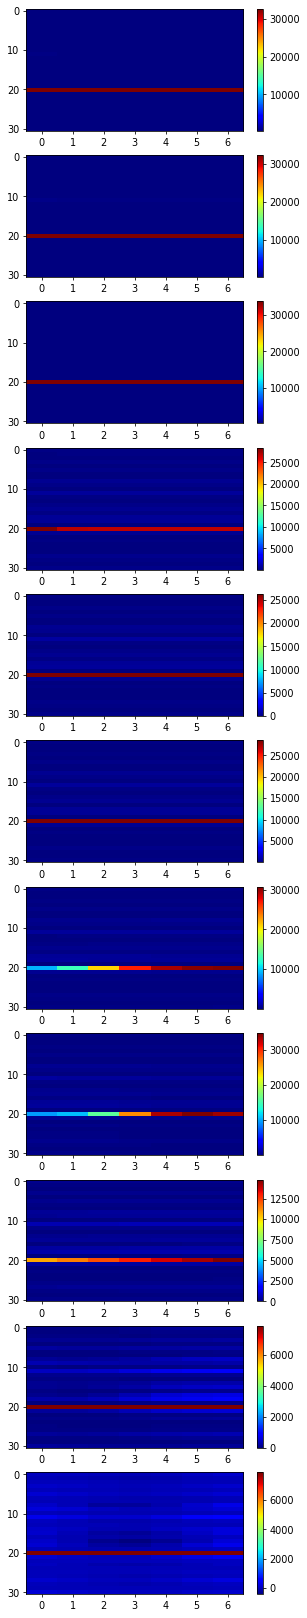

In [92]:
feb_exp = {}
feb_exp['STNN'] = 'ori-stnn_00-07-05-04-46'
feb_exp['STNN-R'] = 'ori-stnn_00-09-05-04-39'
feb_exp['STNN-D'] = 'ori-stnn_00-35-05-04-01'
feb_exp['STNN-v2'] = 'input-stnn_10-45-05-04-27'
feb_exp['STNN-v2-R'] = 'input-stnn_10-46-05-04-09'
feb_exp['STNN-v2-D'] = 'input-stnn_10-47-05-04-02'
feb_exp['STNN-v1'] = 'concat-stnn_10-38-05-04-09'
feb_exp['STNN-v1-R'] = 'concat-stnn_00-06-05-04-07'
feb_exp['STNN-v1-D'] = 'concat-stnn_10-42-05-04-04'
feb_exp['LSTM'] = 'keras-rnn_00-09-05-04-14'
feb_exp['GRU'] = 'keras-rnn_01-16-05-04-26'
feb = {}
feb_pred = {}
for k, v in feb_exp.items():
    feb[k] = result.Exp(v, feb_folder)
    feb_pred[k] = feb[k].pred().numpy().T
plt.figure('Results', figsize=(5, 30), dpi=70)

# plt.subplot(11, 3, 1)
# plt.imshow(test_data, aspect='auto', cmap='jet')
# plt.colorbar()
# plt.title('ground truth')

for i, exp in enumerate(feb_pred):
    plt.subplot(11, 1, i + 1)
    plt.imshow(feb_pred[exp], aspect='auto', cmap='jet')
    plt.colorbar()

    # plt.subplot(11, 3, i * 3 + 3)
    # plt.imshow(np.abs(test_data - pred[exp]), aspect='auto')
    # plt.colorbar()
    # plt.title('{} absolute error'.format(exp))

In [104]:
feb_lis = []
for k, v in feb_exp.items():
    feb_lis.append(v)
feb_df.loc[feb_lis].to_excel('feb.xls')

## Mar Exp

In [102]:
mar_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'output', 'mar'))
mar_result = result.Printer(mar_folder)
pd.options.display.max_rows = None
# a = mar_result.get_df(col=['train_loss', 'test_loss', 'mode']).sort_values('test_loss', ascending=True)
mar_df = mar_result.get_df(col=['train_loss', 'test_loss', 'true_loss', 'mode', 'nhid', 'nlayers', 'nz', 'dropout_d', 'simple_dec', 'seq_length', 'rnn_model']).sort_values('test_loss', ascending=True)
mar_df

,train_loss,test_loss,true_loss,mode,nhid,nlayers,nz,dropout_d,simple_dec,seq_length,rnn_model
ori-stnn_00-04-05-04-51,0,0.0208291,61.0644,None,20,2,10,0.5,NaN,NaN,NaN
keras-rnn_02-07-05-04-11,0.157529,0.0222844,65.3308,NaN,100,4,NaN,NaN,NaN,10,LSTM
keras-rnn_10-43-05-04-05,0.15754,0.0223458,65.5108,NaN,10,4,NaN,NaN,NaN,10,GRU
keras-rnn_01-14-05-04-01,0.157529,0.0223694,65.5801,NaN,100,2,NaN,NaN,NaN,10,LSTM
keras-rnn_01-27-05-04-36,0.157529,0.0226362,66.3623,NaN,100,4,NaN,NaN,NaN,10,GRU
keras-rnn_00-04-05-04-32,0.393322,0.0227362,66.6554,NaN,100,2,NaN,NaN,NaN,5,LSTM
keras-rnn_00-53-05-04-25,0.157528,0.022751,66.6988,NaN,100,2,NaN,NaN,NaN,10,GRU
keras-rnn_03-07-05-04-17,0.604055,0.0228147,66.8854,NaN,100,4,NaN,NaN,NaN,2,LSTM
keras-rnn_02-32-05-04-50,0.604057,0.0228696,67.0464,NaN,100,2,NaN,NaN,NaN,2,GRU
keras-rnn_10-40-05-04-46,0.157534,0.0230558,67.5924,NaN,10,2,NaN,NaN,NaN,10,GRU


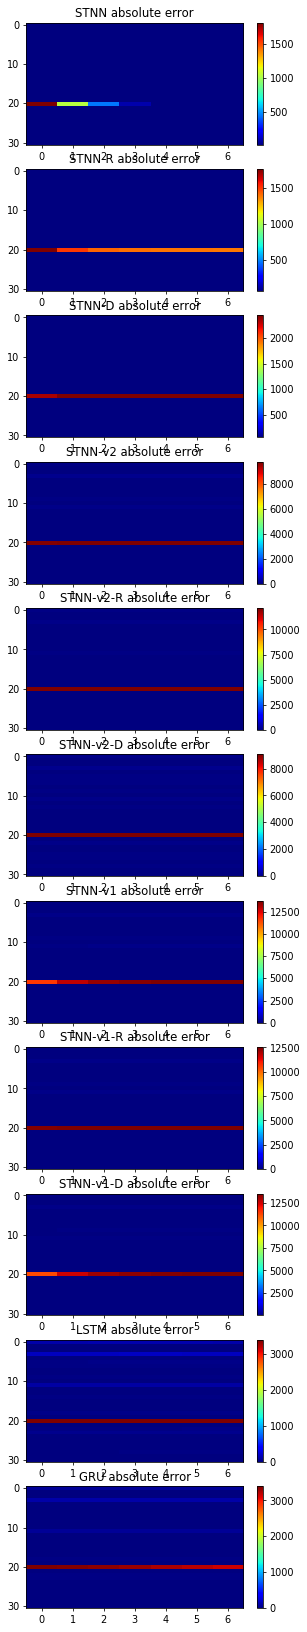

In [96]:
mar_exp = {}
mar_exp['STNN'] = 'ori-stnn_00-04-05-04-51'
mar_exp['STNN-R'] = 'ori-stnn_00-19-05-04-49'
mar_exp['STNN-D'] = 'ori-stnn_00-28-05-04-19'
mar_exp['STNN-v2'] = 'input-stnn_10-46-05-04-19'
mar_exp['STNN-v2-R'] = 'input-stnn_12-22-05-04-14'
mar_exp['STNN-v2-D'] = 'input-stnn_10-48-05-04-02'
mar_exp['STNN-v1'] = 'concat-stnn_12-21-05-04-12'
mar_exp['STNN-v1-R'] = 'concat-stnn_12-21-05-04-45'
mar_exp['STNN-v1-D'] = 'concat-stnn_12-22-05-04-26'
mar_exp['LSTM'] = 'keras-rnn_02-07-05-04-11'
mar_exp['GRU'] = 'keras-rnn_10-43-05-04-05'
mar = {}
mar_pred = {}
for k, v in mar_exp.items():
    mar[k] = result.Exp(v, mar_folder)
    mar_pred[k] = mar[k].pred().numpy().T
plt.figure('Results', figsize=(5, 30), dpi=70)

# plt.subplot(11, 3, 1)
# plt.imshow(test_data, aspect='auto', cmap='jet')
# plt.colorbar()
# plt.title('ground truth')

for i, exp in enumerate(mar_pred):
    plt.subplot(11, 1, i+1)
    plt.imshow(mar_pred[exp], aspect='auto', cmap='jet')
    plt.colorbar()
    plt.title('{} absolute error'.format(exp))


    # plt.subplot(11, 3, i * 3 + 3)
    # plt.imshow(np.abs(test_data - pred[exp]), aspect='auto')
    # plt.colorbar()
    # plt.title('{} absolute error'.format(exp))

In [103]:
mar_lis = []
for k, v in mar_exp.items():
    mar_lis.append(v)
mar_df.loc[mar_lis].to_excel('mar.xlsx')

## Aids LSTM

In [8]:
folder_name = 'aids_LSTM'
model_name = get_model(folder_name)[1]
model_list = model_dir[folder_name]

### The Best Model 

In [ ]:
for model in model_list:
    model = LSTMNet()

In [5]:
outputdir = 'output'
exps = ['stnn']
models = {}
for exp in exps:
    with open(os.path.join(outputdir, exp, 'config.json'), 'r') as f:
        config = json.load(f)
    setup, (train_input, train_output), (test_input, test_data)  = dataset_factory(datadir, dataset, 700, 5)
    model = rnn(29, config['nhid'], config['nlayers'], 29, config['seq_length'])
    state_dict = torch.load(os.path.join(outputdir, exp, 'model.pt'), map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict)
    models[exp] = model

## Results

In [6]:
predictions = {}
for exp in exps:
    model = models[exp]
    model.eval()
    with torch.no_grad():
        prediction = model.generate(test_input, 396)
        predictions[exp] = prediction
        mse =  rmse(prediction, test_data)
        print(prediction.size())
    print('RMSE {}:\t'.format(exp), mse)

torch.Size([396, 29, 1])
RMSE stnn:	 9.350045204162598


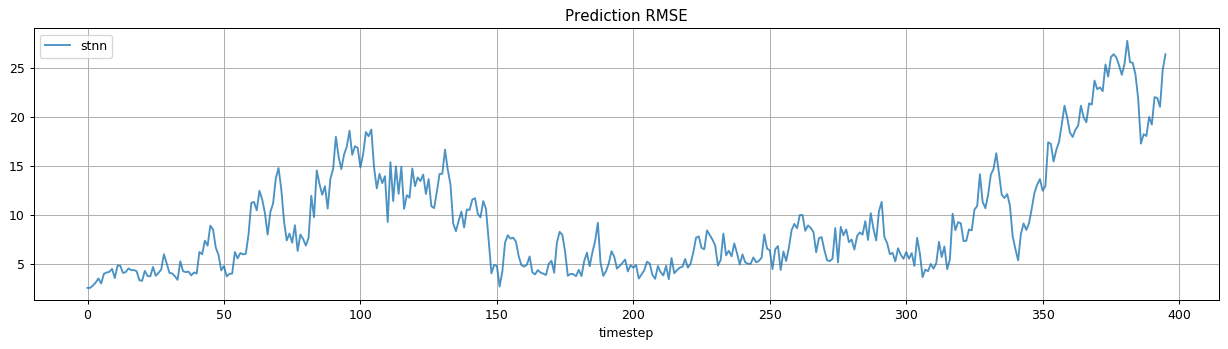

In [7]:
plt.figure('Test plots', figsize=(17, 4), dpi=90)
for exp in exps:
    with open(os.path.join(outputdir, exp, 'logs.json'), 'r') as f:
        logs = json.load(f)

    plt.plot([logs['test_epoch.ts.{}.rmse'.format(ts)][-1] for ts in range(396)], label=exp, alpha=0.8)

plt.grid()
plt.title('Prediction RMSE')
plt.xlabel('timestep')
plt.legend()

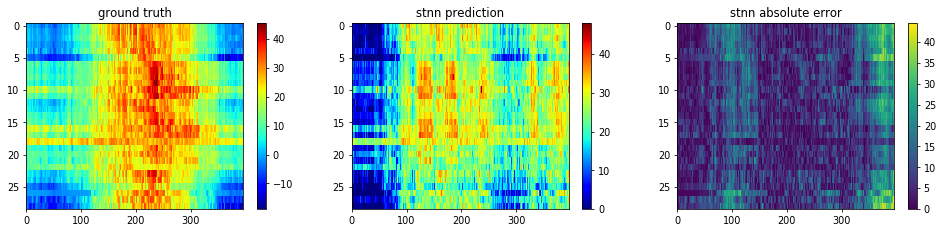

In [8]:
plt.figure('Results', figsize=(17, 12), dpi=70)

plt.subplot(3, 3, 1)
plt.imshow(test_data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('ground truth')

for i, exp in enumerate(exps):
    plt.subplot(3, 3, i * 3 + 2 + i // 3)
    plt.imshow(predictions[exp].squeeze().numpy().T, aspect='auto', cmap='jet')
    plt.colorbar()
    plt.title('{} prediction'.format(exp))

    plt.subplot(3, 3, i * 3 + 3 + i // 3)
    plt.imshow(test_data.sub(predictions[exp]).abs().squeeze().numpy().T, aspect='auto')
    plt.colorbar()
    plt.title('{} absolute error'.format(exp))